<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/unet/unet_lung_cancer_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🫁 肺がんのセグメンテーションとは

## 🏥 医療現場での課題

現在、医療現場では肺がんの早期発見が重要な課題となっています。肺がんは初期症状が少なく、発見が遅れがちな病気です。しかし、早期に発見できれば治療の選択肢が広がり、患者さんの予後も大幅に改善できます。

そこで活用されているのが**CT（コンピュータ断層撮影）**という技術です。CTでは、X線を使って身体を薄くスライスしたような画像を撮影できます。まるで食パンを薄く切って、その断面を一枚ずつ見ているような感じです。

## 🔍 セグメンテーションという技術

**セグメンテーション**とは、画像を意味のある領域に分割する技術のことです。例えば、一枚の写真から「空」「建物」「道路」「人」などの部分を自動的に識別して色分けすることを想像してみてください。

医用画像におけるセグメンテーションでは、CT画像から「正常な肺組織」「がん領域」「血管」「気管支」といった、注目したい領域に色塗りをします。

```
元のCT画像           セグメンテーション結果
⬛⬛⬛⬜⬜⬛    →   ⬜⬜⬜⬜⬜⬜
⬛⬜⬜⬜⬛⬛    →   ⬜⬜🔴🔴⬜⬜
⬛⬜⬜⬜⬜⬛    →   ⬜🔴🔴🔴🔴⬜  (がん領域を赤で塗る)
⬛⬛⬜⬜⬛⬛    →   ⬜⬜🔴🔴⬜⬜
⬛⬛⬛⬜⬛⬛    →   ⬜⬜⬜⬜⬜⬜
⬛⬛⬛⬛⬛⬛    →   ⬜⬜⬜⬜⬜⬜
```

## 🎯 なぜセグメンテーションが重要なのか

### 医師の診断支援
放射線科医は一日に何百枚ものCT画像を確認します。小さながん病変を見落とさないよう、AIが自動的に疑わしい領域をマーキングできれば、診断精度の向上と医師の負担軽減につながります。

### 治療計画の作成
がんの正確な位置と大きさがわかれば、手術や放射線治療の計画をより精密に立てることができます。健康な組織への影響を最小限に抑えながら、効果的な治療を行えます。

### 治療効果の追跡
治療前後でがんの大きさや形を正確に測定できれば、治療効果を客観的に評価できます。

## 📊 今回使用するデータ

今回の実習では、Medical Segmentation Decathlon（医用画像セグメンテーション競技会）で提供された肺がんのCTデータを使用します。このデータセットには：

- 実際の患者さんのCT画像（匿名化済み）
- 専門医が手作業で作成した正解ラベル
- 世界中の研究者が使用する標準的なデータ

が含まれています。

## 🤔 これから学ぶこと

このセグメンテーション技術を実現するために、私たちは以下のことを学びます：

1. **データの準備**: 医用画像データの読み込みと前処理
2. **画像の理解**: デジタル画像がどのように構成されているか
3. **分類の発想**: アヤメ分類との共通点を見つける
4. **U-Netモデル**: セグメンテーション専用のAI技術
5. **実際の体験**: 本物のデータでAIを動かす



# 🔍 データを確認してみよう

実際にダウンロードしたデータを確認してみましょう：
この表示で以下のことがわかります：

- **グレースケール画像**: CT画像は白黒（グレースケール）で表示されます
- **赤い部分**: これがガン領域として専門医が標識した部分です
- **画像サイズ**: 64×64 = 4,096個の画素で構成されています

続きを読み込んで表示します ...


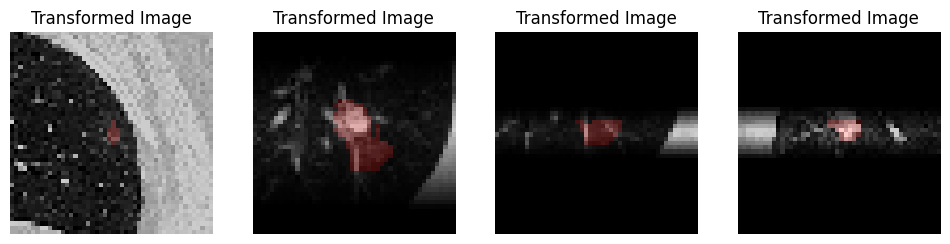

In [10]:
# @title データを読み込みましょう

try:
  print("続きを読み込んで表示します", flag)

except:
  !pip install albumentations
  print("データを読み込むのでしばらくかかります...")

  import albumentations as A
  from albumentations.pytorch import ToTensorV2
  from torch.utils.data import Dataset
  import numpy as np
  import h5py
  import torch
  import torch.nn as nn
  import torch.optim as optim
  import matplotlib.pyplot as plt
  from torch.utils.data import DataLoader, TensorDataset
  from torchvision import transforms
  import torch.nn.functional as F

  # Google Colabでの日本語フォント設定
  !pip install japanize-matplotlib -q
  import japanize_matplotlib

  import os
  import gdown
  # ディレクトリの作成
  directory = '/content/drive/MyDrive/education/data/msd/lung_2mm/'
  os.makedirs(directory + "nii/", exist_ok=True)

  # GitHubからファイルをダウンロードする
  base_url = 'https://github.com/shizoda/data/raw/main/msd/lung_2mm/'
  file_names = ['train_patches.h5', 'val_patches.h5', 'test_patches.h5', 'nii/lung_001.nii.gz', 'nii/lung_009.nii.gz', 'nii/lung_016.nii.gz']

  for file_name in file_names:
      url = base_url + file_name
      output = directory + file_name
      if not os.path.exists(output):  # すでにファイルが存在しない場合にのみダウンロード
          gdown.download(url, output, quiet=False)

  class CustomDataset(Dataset):
      def __init__(self, images, labels, transform=None):
          self.images = images
          self.labels = labels
          self.transform = transform

      def __len__(self):
          return len(self.images)

      def __getitem__(self, idx):
          image = self.images[idx]
          label = self.labels[idx]

          if self.transform:
              # Albumentationsの変換を適用
              augmented = self.transform(image=image, mask=label)
              image = augmented['image']
              label = augmented['mask']

          return image, label

  train_transform = A.Compose([
      A.Rotate(limit=10, p=0.5),  # 50%の確率で回転
      A.HorizontalFlip(p=0.3)  # 30%の確率で水平方向に反転
  ])

  def load_data(h5_file):
      # HDF5ファイルから画像とラベルを読み込む関数
      with h5py.File(h5_file, 'r') as h5f:
          images = h5f['images'][:]
          labels = h5f['labels'][:]
      return images, labels

  # データ（HDF5 ファイル、拡張子 .h5 ）の読み込みと準備
  train_images, train_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/train_patches.h5')
  val_images, val_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/val_patches.h5')
  test_images, test_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/test_patches.h5')

  # PyTorchのTensorに変換
  # トレーニングデータセットにのみ変換を適用
  # train_dataset = TensorDataset(torch.tensor(train_images, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32))
  train_dataset = CustomDataset(train_images, train_labels, transform=train_transform)
  val_dataset = TensorDataset(torch.tensor(val_images, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.float32))
  test_dataset =TensorDataset(torch.tensor(test_images, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.float32))

  # DataLoaderの設定
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32)
  test_loader = DataLoader(test_dataset, batch_size=32)

  import matplotlib.pyplot as plt
  def show_images(loader, num_images=4):
      images, labels = next(iter(loader))
      plt.figure(figsize=(12, 8))
      for i in range(num_images):
          plt.subplot(1, num_images, i+1)

          # TensorをNumpy配列に変換
          image_np = images[i].numpy().squeeze()  # グレースケール化
          label_np = labels[i].numpy().squeeze()  # ラベルもNumpy配列に変換

          # グレースケール画像を表示
          plt.imshow(image_np, cmap='gray')  # カラーマップを'gray'に設定
          plt.title("Transformed Image")
          plt.axis('off')

          # ラベルを赤で半透明に表示
          plt.imshow(np.dstack((label_np, np.zeros_like(label_np), np.zeros_like(label_np))), alpha=0.2)
      plt.show()

  flag = "..."

# 変換後のトレーニングデータの画像を表示
show_images(train_loader)

# 📱 画素を分類するという発想

## 🖼️ デジタル画像の正体

先ほどダウンロードしたCT画像を見る前に、デジタル画像がどのような仕組みになっているか理解しましょう。

実は、デジタル画像は**たくさんの小さな点の集まり**です。この小さな点を**画素（ピクセル）**と呼びます。

### 身近な例で考えてみよう

スマートフォンのカメラで「1200万画素」という表示を見たことがありませんか？これは、写真が1200万個の小さな点で構成されているという意味です。

例えば、8×8の小さな画像を考えてみましょう：

```
⬜⬜⬜🟫🟫⬜⬜⬜
⬜⬜🟫🟫🟫🟫⬜⬜
⬜🟫🟫🟫🟫🟫🟫⬜
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫
⬜🟫🟫🟫🟫🟫🟫⬜
⬜⬜🟫🟫🟫🟫⬜⬜
⬜⬜⬜🟫🟫⬜⬜⬜
```

この例では64個（8×8）の画素が集まって、円の形を作っています。実際のCT画像は、これが何百×何百という規模になったものです。

## 💡 アヤメ分類との類似点を発見

ここで重要な気づきがあります。**セグメンテーションは、実はアヤメ分類とまったく同じことをしているのです。**

### 🌸 アヤメ分類の場合
```
アヤメ1輪 → [がくの長さ: 5.1cm, がくの幅: 3.5cm] → 🧠AI → ヒオウギアヤメ
```

### 📱 画素分類の場合
```
画素1個 → [明るさ: 150, 周辺の様子: ...] → 🧠AI → ガン領域
```

**やっていることは全く同じです！**

- **分類対象**: アヤメ1輪 → 画素1個
- **特徴量**: がくの長さ・幅 → 明るさ・周辺情報
- **分類結果**: アヤメの種類 → ガン領域か正常組織か
- **手法**: データに基づく統計的計算

## 🎯 画素の特徴量とは

画素にも、アヤメの「がくの長さ」のような**特徴量**があります：

### 基本的な特徴量
- **明るさ**: その画素の輝度値
- **位置**: 画像のどこにあるか（座標）

### 重要な周辺情報
- **近隣画素**: 隣の画素の明るさはどうか
- **テクスチャ**: 周辺の模様（ザラザラ・なめらか）
- **境界**: 明るさが急に変わる場所があるか

例えば、同じ明るさ（150）の画素でも：

```
パターン1: 周辺も同じような明るさ
150 148 152
149 150 151  ← 正常組織の可能性
148 149 150

パターン2: 周辺が不規則
180 120 200
90  150 160  ← ガン領域の可能性
140 190 110
```

周辺の情報によって、同じ画素でも意味が変わってきます。

## 🧮 セグメンテーションの処理手順

実際のセグメンテーションでは以下の手順で処理が行われます：

1. **画像入力**: 64×64のCT画像を受け取る
2. **特徴抽出**: 各画素とその周辺の特徴を計算
3. **分類実行**: 画素1つずつを「ガン/正常」に分類
4. **結果出力**: 4,096個の分類結果をまとめる

つまり、**4,096回のアヤメ分類を同時に実行している**ようなものです。

## 🎪 理解度チェック

以下の質問について考えてみてください：

1. デジタル画像が「画素の集まり」だということは理解できましたか？
2. アヤメ分類と画素分類の共通点は何でしょうか？
3. なぜ画素分類では「周辺情報」が重要なのでしょうか？

これらの概念が理解できたら、いよいよU-Netモデルの構築に進みます。

## 🤖 U-Netの役割

この「画素1つずつの分類」を効率的に行うのが**U-Net**というAIモデルです。

U-Netの特徴：
- **並列処理**: 4,096個の画素を同時に分類
- **周辺考慮**: 各画素の周辺情報を巧妙に利用
- **高精度**: 医用画像に特化した設計

次のステップでは、実際にU-Netモデルを構築して、この「画素分類」を体験してみましょう。

### U-Net 構造の図示

詳しく理解したい人は、この次のソースコードを開き、自分で類似の図を描いてみてください。まずは実行して、結果を見てみましょう。

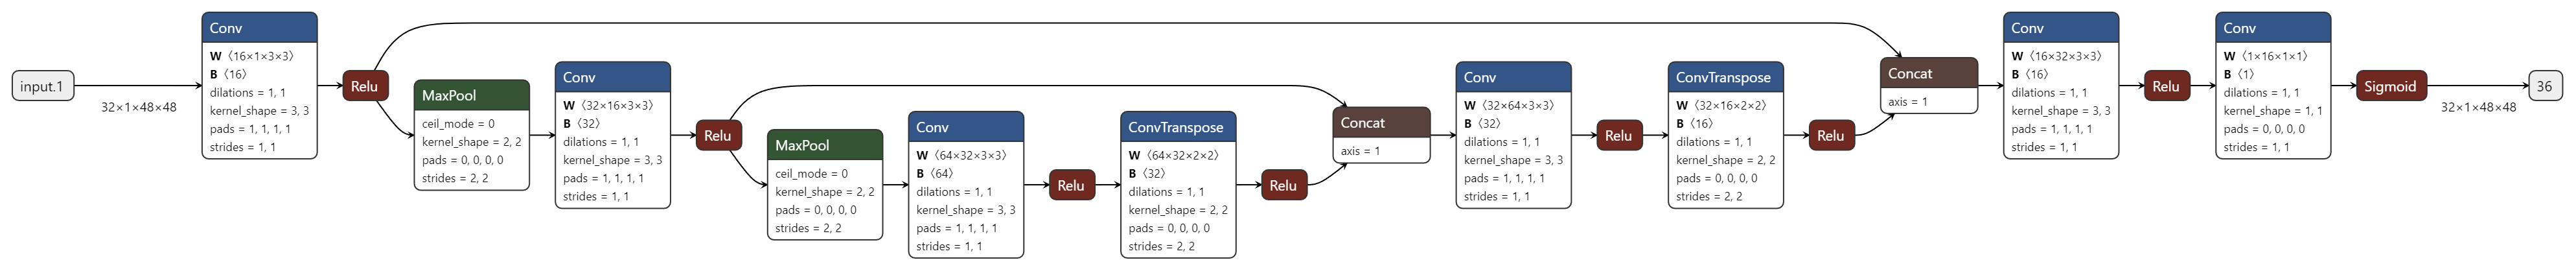

In [13]:
# @title U-Net の実装
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 初期チャネル数
        self.base_channels = 16

        # Encoder（ダウンサンプリング）
        self.enc_conv1 = nn.Conv2d(1, self.base_channels, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(self.base_channels, self.base_channels * 2, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(self.base_channels * 2, self.base_channels * 4, kernel_size=3, padding=1)

        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder（アップサンプリング）
        self.dec_upconv3 = nn.ConvTranspose2d(self.base_channels * 4, self.base_channels * 2, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(self.base_channels * 4, self.base_channels * 2, kernel_size=3, padding=1)
        self.dec_upconv2 = nn.ConvTranspose2d(self.base_channels * 2, self.base_channels, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(self.base_channels * 2, self.base_channels, kernel_size=3, padding=1)

        # Final Layer
        self.final_conv = nn.Conv2d(self.base_channels, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Decoder
        dec3 = torch.cat((F.relu(self.dec_upconv3(enc3)), enc2), dim=1)
        dec3 = F.relu(self.dec_conv3(dec3))
        dec2 = torch.cat((F.relu(self.dec_upconv2(dec3)), enc1), dim=1)
        dec2 = F.relu(self.dec_conv2(dec2))

        # Final segmented output
        # out = torch.sigmoid(self.final_conv(dec2))
        out = self.final_conv(dec2)

        return out
model = UNet()                # 上記で実装している U-Net
print(model)
print("U-Net のロードが完了しました")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

UNet(
  (enc_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec_upconv3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec_conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_upconv2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (dec_conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final_conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)
U-Net のロードが完了しました


# 🧠 U-Netの学習プロセス

## 🎯 U-Netの基本的な動作

前回学んだように、セグメンテーションは「画素1つずつの分類」でした。U-Netは、この作業を効率的に行う特別なAIモデルです。

### 入力と出力の関係

U-Netの動作はとてもシンプルです：

```
入力: 64×64のCT画像     出力: 64×64の確率マップ
⬜⬜⬛⬜            →     0.1 0.1 0.2 0.1
⬜🟫⬛⬜                   0.2 0.9 0.8 0.2
⬛⬛🟫⬜                   0.1 0.2 0.1 0.1
⬜⬜⬜⬜                   0.1 0.1 0.1 0.1
```

**重要なポイント**は、入力画像と出力画像のサイズが全く同じということです。64×64の画像を入れると、64×64の結果が出てきます。

しかし、出力される数値の意味が違います。入力が「画素の明るさ」だったのに対し、出力は「その画素がガン領域である確率」を表しています。

### 確率の読み方

出力される数値は0.0から1.0の間の値で：
- **0.0に近い値**：その画素は正常組織の可能性が高い
- **0.5付近の値**：判断が困難（どちらとも言えない）
- **1.0に近い値**：その画素はガン領域の可能性が高い

上の例では、左上から2番目、2行目の画素が0.9という高い値を示しているので、この画素は「ガン領域である可能性が90%」ということになります。

## 📚 学習とは何か：アヤメ分類との類似

### アヤメ分類での学習を振り返る

アヤメ分類では、150個のデータを使って「がくの長さが〇cm、幅が△cmの時は、ヒオウギアヤメの可能性が高い」という法則を学習しました。

### U-Netでの学習プロセス

U-Netでも基本的には同じことをしています：

1. **大量のデータを見る**：何千枚ものCT画像とその正解ラベル
2. **パターンを見つける**：「この明るさパターンの時はガンの可能性が高い」
3. **内部の計算方法を調整**：予測精度が上がるように内部の重みを修正

### 学習の具体的な流れ

```
ステップ1: 予測を行う
CT画像 → U-Net → 予測結果（各画素の確率）

ステップ2: 正解と比較
予測：0.1 0.1 0.2 0.1
正解：0   0   1   0     ← 専門医が作成した正解ラベル
差分：大きな違いがある！

ステップ3: 内部を少しずつ修正
「3番目の画素の予測が外れている。次回はもっと正確になるように調整しよう」
```

この「予測→比較→修正」のサイクルを何百回、何千回と繰り返すことで、U-Netは徐々に正確な予測ができるようになります。

## 🔄 反復学習の重要性

### なぜ繰り返し学習が必要なのか

U-Netの学習では、最初はランダムな予測しかできません。しかし、正解と比較して間違いを修正する作業を繰り返すことで、徐々に正確になっていきます。

**最初の状態**：ランダムな予測しかできない
```
正解：0 0 1 0
予測：1 0 0 1  ← 全然当たっていない
```

**100回学習後**：少し正確になる
```
正解：0 0 1 0
予測：0 1 1 0  ← 少し改善
```

**500回学習後**：かなり正確な予測ができる
```
正解：0 0 1 0
予測：0 0 1 0  ← ほぼ一致している
```

### 学習の進行を監視する

学習がうまく進んでいるかを確認するために、以下のデータを記録します：

- **訓練用データでの成績**：学習に使っているデータでどれだけ正確か
- **検証用データでの成績**：学習に使っていない新しいデータでどれだけ正確か

理想的には、両方の成績が学習を重ねるごとに向上していきます。ただし、時として「訓練データでは成績が良いが、新しいデータでは成績が悪い」という状況（過学習）が起こることもあります。

## ⚙️ 実際の学習実行

これから実行するプログラムでは：

1. **500回の学習サイクル**を実行します
2. **各サイクルごとに成績を表示**して進捗を確認します
3. **最も成績の良いモデル**を自動的に保存します
4. **学習が停滞したら自動停止**する機能も含まれています

学習には時間がかかりますが、これは「何千枚もの画像を見て、何千回も予測と修正を繰り返している」からです。アヤメ分類の150個のデータとは規模が全く違います。

## 🔍 学習結果の可視化

学習が完了すると、以下のようなグラフが表示されます：

- **横軸**：学習回数（エポック）
- **縦軸**：予測の正確さ（損失）
- **2本の線**：訓練用データと検証用データの成績

このグラフを見ることで、学習が順調に進んだかどうかを確認できます。

---

## 📋 応用的な技術解説

ここから先は、より詳細な技術的内容です。とりあえず読み飛ばしても構いません。

### 損失関数とは何か

**損失関数**とは、「予測がどれだけ間違っているか」を数値で表す仕組みです。

アヤメ分類では、単純に「当たった・外れた」で判定できました。しかし、セグメンテーションでは各画素が0から1の確率値を出すため、「どれだけ外れているか」を計算する必要があります。

例えば：
```
正解：1（ガン領域）
予測：0.9 → 損失は小さい（ほぼ正解）
予測：0.1 → 損失は大きい（大きく間違い）
```

今回使用する「Dice Loss」は医用画像に特化した損失関数で、予測した領域と正解領域がどれだけ重なっているかを効率的に計算します。この数値が小さいほど、より正確な予測ができていることを意味します。

### オプティマイザとは何か

**オプティマイザ**とは、「どうやって予測精度を改善するか」の方法を決める仕組みです。

U-Netの内部には何百万個もの「重み」と呼ばれる数値があります。これらの数値を少しずつ調整することで、予測精度を向上させます。

```
学習前の重み：0.5, 0.3, 0.8, ...
↓ 予測が外れた場合
学習後の重み：0.6, 0.2, 0.7, ...
```

「Adam」というオプティマイザは、このような重みの調整を効率的に行う方法の一つです。単純に同じ幅で調整するのではなく、過去の学習履歴も考慮して、各重みを個別に最適な幅で調整します。

### Early Stopping とは何か

**Early Stopping**とは、「学習をいつ止めるか」を自動で判断する仕組みです。

学習を続けすぎると、訓練データには非常に詳しくなるものの、新しいデータに対する予測精度が下がってしまうことがあります（過学習）。

そこで、検証用データでの成績が10回連続で改善されない場合、「これ以上学習しても意味がない」と判断して自動的に学習を停止します。これにより、過学習を防ぎ、計算時間も節約できます。

---

それでは、実際に学習を開始してみましょう。学習の様子を観察して、U-Netがどのように賢くなっていくかを確認してください。

Epoch 1/500, Train Loss: 0.9241, Val Loss: 0.9279
Epoch 2/500, Train Loss: 0.9214, Val Loss: 0.9275
Epoch 3/500, Train Loss: 0.9239, Val Loss: 0.9270
Epoch 4/500, Train Loss: 0.9207, Val Loss: 0.9265
Epoch 5/500, Train Loss: 0.9226, Val Loss: 0.9258
Epoch 6/500, Train Loss: 0.9260, Val Loss: 0.9247
Epoch 7/500, Train Loss: 0.9256, Val Loss: 0.9229
Epoch 8/500, Train Loss: 0.9139, Val Loss: 0.9202
Epoch 9/500, Train Loss: 0.9101, Val Loss: 0.9178
Epoch 10/500, Train Loss: 0.9094, Val Loss: 0.9161
Epoch 11/500, Train Loss: 0.9080, Val Loss: 0.9140
Epoch 12/500, Train Loss: 0.9026, Val Loss: 0.9121
Epoch 13/500, Train Loss: 0.9063, Val Loss: 0.9106
Epoch 14/500, Train Loss: 0.8930, Val Loss: 0.9082
Epoch 15/500, Train Loss: 0.8859, Val Loss: 0.9066
Epoch 16/500, Train Loss: 0.8890, Val Loss: 0.9031
Epoch 17/500, Train Loss: 0.8797, Val Loss: 0.8987
Epoch 18/500, Train Loss: 0.8576, Val Loss: 0.8935
Epoch 19/500, Train Loss: 0.8505, Val Loss: 0.8900
Epoch 20/500, Train Loss: 0.8477, Val Lo

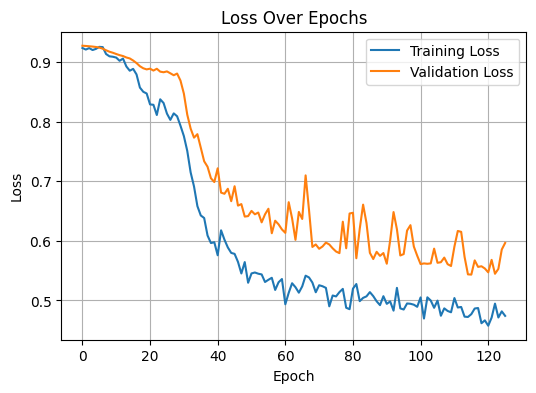

In [14]:
# @title
# モデル、オプティマイザー、損失関数の定義
optimizer = optim.Adam(model.parameters(), lr=1e-4)

class DiceLoss(nn.Module):
    def __init__(self, smooth=0.1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice

# 損失関数 Dice Loss
criterion = DiceLoss()

def train(model, device, train_loader, optimizer, criterion):
    """トレーニングステップ"""
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(images))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, device, val_loader, criterion):
    """バリデーションステップ"""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images))
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# トレーニングとバリデーション
num_epochs = 500
best_val_loss = float('inf')
train_losses, val_losses = [], []
no_improve_count = 0  # 改善されない回数をカウント

for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss = validate(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_count = 0  # 改善されたのでカウントをリセット
        torch.save(model.state_dict(), '/content/drive/MyDrive/education/data/msd/lung_2mm/best_model.pth')
    else:
        no_improve_count += 1  # 改善されない回数をインクリメント
        if no_improve_count >= 10:  # 10回連続で改善されない場合
            print('Early stopping')
            break

def plot_history(train_losses, val_losses):
    """学習履歴をプロット"""
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 学習履歴のプロット
plot_history(train_losses, val_losses)

# 🧪 モデルの評価と結果の可視化

## 🎯 学習完了後の次のステップ

500回（またはそれより少ない回数）の学習が完了しました。U-Netは訓練用データから「どのような画素パターンがガン領域を示すか」という法則を学習しました。

しかし、本当に重要なのは**「学習に使っていない新しいデータに対してどれだけ正確に予測できるか」**です。これは、アヤメ分類で新しいアヤメの写真を見せた時に正しく種類を判定できるかということと同じです。

## 📊 性能評価の方法：Dice係数

### Dice係数とは

U-Netの性能を測るために「Dice係数」という指標を使用します。これは、予測した領域と正解の領域がどれだけ重なっているかを0から1の数値で表したものです。

```
Dice係数の意味：
1.0 = 完璧（予測と正解が完全に一致）
0.8 = かなり良い（80%程度一致）
0.5 = 普通（50%程度一致）
0.0 = 全く駄目（全く一致しない）
```

### 具体例で理解する

4×4の小さな画像で考えてみましょう：

**例1：良い予測**
```
　　　正解：　　　　　　　予測：
     ⬜⬜🔴⬜         ⬜⬜🔴⬜
     ⬜🔴🔴⬜         ⬜🔴🔴⬜
     ⬜⬜🔴⬜         ⬜⬜🔴⬜
     ⬜⬜⬜⬜         ⬜⬜⬜⬜
Dice係数：1.0（完全一致）
```

**例2：まずまずの予測**
```
　　　正解：  　　　　　　予測：
     ⬜⬜🔴⬜         ⬜🔴🔴⬜
     ⬜🔴🔴⬜         ⬜🔴🔴🔴
     ⬜⬜🔴⬜         ⬜⬜⬜⬜
     ⬜⬜⬜⬜         ⬜⬜⬜⬜
Dice係数：0.7程度（概ね一致）
```

## 🖼️ 結果の可視化で見えるもの

実行される可視化では、10枚のテスト画像について以下の4段階が表示されます：

### 1行目：元のCT画像
- **グレースケール画像**：撮影されたままのCT画像
- ガン領域も正常組織もすべて含まれた原画像

### 2行目：予測結果（確率マップ）
- **グレースケール画像**：同じCT画像
- **カラフルな領域**：U-Netが予測したガン領域の確率
  - **赤・黄色**：ガンの可能性が高い（確率0.7-1.0）
  - **緑・青色**：ガンの可能性が中程度（確率0.3-0.7）
  - **暗い色**：ガンの可能性が低い（確率0.0-0.3）

### 3行目：予測結果のラベル
- **グレースケール画像**：同じCT画像
- **赤い領域**：AIが最終的に「ガン領域」と判定した部分（確率0.5以上）

### 4行目：正解ラベル
- **グレースケール画像**：同じCT画像
- **赤い領域**：放射線科医が手作業で標識したガン領域ガン領域も正常組織もすべて含まれた原画像

### 2行目：AIによる予測結果
- **グレースケール画像**：同じCT画像
- **カラフルな領域**：U-Netが予測したガン領域の確率
  - **赤・黄色**：ガンの可能性が高い（確率0.7-1.0）
  - **緑・青色**：ガンの可能性が中程度（確率0.3-0.7）
  - **暗い色**：ガンの可能性が低い（確率0.0-0.3）

### 3行目：医師による正解ラベル
- **グレースケール画像**：同じCT画像
- **赤い領域**：放射線科医が手作業で標識したガン領域


✅ 日本語フォント設定完了
🧪 テストデータでの性能評価を開始...
📊 Mean Dice Score on Test Data: 0.4608
🖼️ 結果を可視化中...


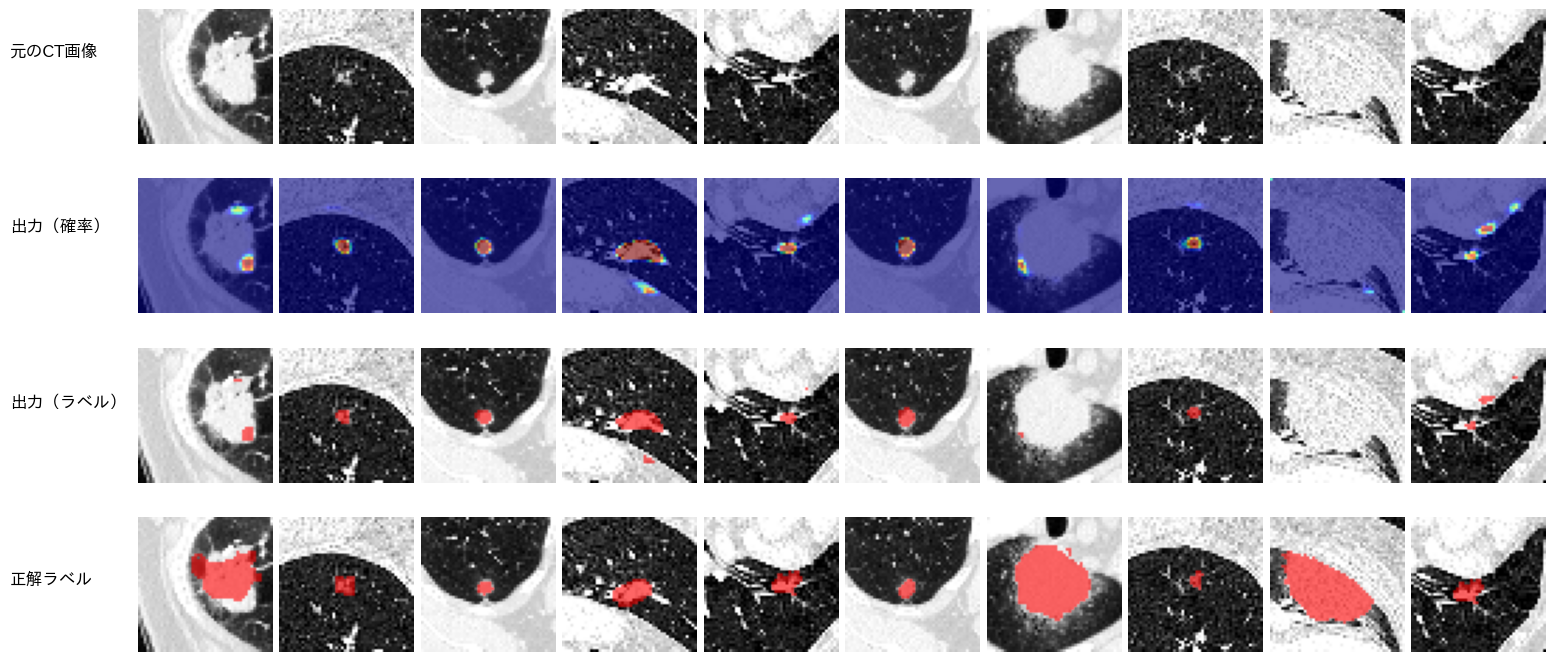

✅ 可視化完了！


In [25]:
# @title  テスト実行

import random

# フォント設定
plt.rcParams['font.size'] = 12
print("✅ 日本語フォント設定完了")

def dice_coeff(pred, target):
    """Dice係数を計算"""
    smooth = 1.
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# モデルを評価モードに設定
print("🧪 テストデータでの性能評価を開始...")
model.eval()
dice_scores = []

# テストデータに対する精度の計算
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))
        dice_scores.append(dice_coeff(outputs, labels))

# 平均Diceスコア
mean_dice = torch.mean(torch.tensor(dice_scores))
print(f'📊 Mean Dice Score on Test Data: {mean_dice.item():.4f}')

import numpy as np
import matplotlib.colors as mcolors

print("🖼️ 結果を可視化中...")
# ランダムに10枚の画像を選択して可視化
indices = random.sample(range(len(test_dataset)), 10)
fig = plt.figure(figsize=(16, 8))  # 4行でもコンパクトに

for i, idx in enumerate(indices, 1):
    image, label = test_dataset[idx]
    image, label = image.to(device).unsqueeze(0), label.to(device).unsqueeze(0)
    pred = torch.sigmoid(model(image)).squeeze(0).cpu()
    pred_binary = (pred > 0.5).float()  # 0.5で閾値処理してバイナリマスク作成

    # 1行目：元のCT画像
    plt.subplot(4, 10, i)
    plt.imshow(image.cpu().squeeze(0)[0,...], cmap='gray')
    plt.axis('off')

    # 2行目：予測結果（確率マップ）
    plt.subplot(4, 10, i + 10)
    plt.imshow(image.cpu().squeeze(0)[0,...], cmap='gray')
    plt.imshow(pred.cpu().detach().numpy().squeeze(0), cmap='jet', alpha=0.6)
    plt.axis('off')

    # 3行目：予測結果のラベル（0.5で閾値処理）
    plt.subplot(4, 10, i + 20)
    plt.imshow(image.cpu().squeeze(0)[0,...], cmap='gray')
    colors = [(1, 0, 0, a) for a in np.linspace(0, 1, 256)]
    cmap_red = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=256)
    plt.imshow(pred_binary.cpu().detach().numpy().squeeze(0), cmap=cmap_red, alpha=0.6)
    plt.axis('off')

    # 4行目：正解ラベル
    plt.subplot(4, 10, i + 30)
    plt.imshow(image.cpu().squeeze(0)[0,...], cmap='gray')
    plt.imshow(label.cpu().squeeze(0)[0,...], cmap=cmap_red, alpha=0.6)
    plt.axis('off')

# 各行の左側に日本語キャプションを追加（コンパクト配置）
plt.figtext(0.02, 0.85, '元のCT画像', va='center', fontsize=12, weight='bold')
plt.figtext(0.02, 0.63, '出力（確率）', va='center', fontsize=12, weight='bold')
plt.figtext(0.02, 0.41, '出力（ラベル）', va='center', fontsize=12, weight='bold')
plt.figtext(0.02, 0.19, '正解ラベル', va='center', fontsize=12, weight='bold')

# 行間を大幅に詰めてコンパクトに
plt.subplots_adjust(left=0.1, right=0.98, top=0.95, bottom=0.05, hspace=-0.2, wspace=0.05)
plt.show()

print("✅ 可視化完了！")

## 💡 結果から読み取れること

### 成功例を見つける
2行目（AIの予測）と3行目（医師の正解）で赤い領域がよく一致している場合、U-Netが正確に予測できたことを示しています。これは、学習データから適切なパターンを習得できた証拠です。

### 失敗例から学ぶ
2行目と3行目の赤い領域が大きく異なっている場合もあるでしょう。これは以下の理由が考えられます：
- その画像に特有の珍しいパターンがあった
- 学習データに類似例が少なかった  
- ガン領域の境界が曖昧で判定が困難だった

### 確率の解釈
2行目の確率は「U-Netの確信度」も表しています。鮮やかな赤色の部分は「この画素は99%ガン領域だ」と確信している場所で、薄い色の部分は「おそらくガン領域だが、確証はない」という判断を示しています。

実際の医療現場では、このような可視化結果を医師が確認し、最終的な診断判断を行います。AIは診断支援ツールとして活用されるものです。

---

# 🎊 実習のまとめ

## 🌸 アヤメから画素へ：概念の発展

この実習を通じて、皆さんは以下の概念の発展を体験しました：

**N-gram統計**（単語の出現パターン）→ **アヤメ分類**（花の特徴による分類）→ **画素分類**（医用画像の各画素の分類）

どの段階でも共通していたのは：
- 大量のデータから法則を見つける
- 特徴量に基づいて分類を行う  
- 統計的計算による予測
- 新しいデータに対する汎化

## 🔬 医用画像AIの本質

今回学んだU-Netによるセグメンテーションも、本質的には**データに基づく計算**でした。アヤメ分類で150個のデータから「がくの長さと幅の関係」を学んだように、U-Netは何千枚の画像から「画素の明るさパターンとガン領域の関係」を学習したのです。

## 🏥 医療現場での活用と限界

**活用の可能性**
- 放射線科医の診断支援
- 見落としリスクの軽減
- 診断時間の短縮
- 治療計画の精密化

**技術的な限界**
- 学習データにない珍しいケースへの対応
- 確率的予測のため、100%の精度は期待できない
- 最終診断は必ず医師が行う必要がある

### 🚀 さらなる発展

医用画像AIは現在も急速に発展している分野です。この基礎的な理解を踏まえて、以下のような発展的な内容も学べます：

- より高精度なモデル（Transformer系モデル等）
- 3次元画像の処理
- 複数の病変の同時検出
- 他の医用画像（MRI、超音波等）への応用

### 💭 最終的なメッセージ

AIや機械学習と聞くと複雑で難しいものに感じるかもしれませんが、今回の実習で体験したように、その根本にあるのは**データから規則性を見つける計算**です。

N-gramで英語の文章パターンを学び、アヤメの特徴で種類分類を学び、そして画素の特徴でガン領域の分類を学ぶ。規模や複雑さは異なりますが、基本的な考え方は一貫しています。

この理解を基礎として、皆さんがさらに高度な機械学習技術に興味を持ち、将来の医療や社会の発展に貢献していただければと思います。

---

*🎉 お疲れさまでした！*